In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

import fastcluster as fc

CPU times: user 1.13 s, sys: 365 ms, total: 1.49 s
Wall time: 2.32 s


In [6]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        pmtall_2 = np.empty((pmtall.shape))
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
            pmtall_2[i] = pmtall[i] * 2.
#         print(pmtall[0])
#         print(pmtall_2[0])
        label1 = np.ones(len(pmtall))
        label2 = np.ones(len(pmtall_2))*2
        
        pmtall = normalize(pmtall, axis=1,norm="l2")
        pmtall_2 = normalize(pmtall_2, axis=1,norm="l2")
        self.waveform = np.concatenate((pmtall,pmtall_2),axis=0)
        
        plt.figure()
        plt.plot(np.mean(pmtall,axis=0))
        plt.plot(np.mean(pmtall_2,axis=0))
        plt.xlim(50,250)
        plt.show()
        
        label_s = np.concatenate((label1,label2),axis=0)
        self.label = label_s.astype(int)
        del pmtall, pmtall_2, pedestal, pedestal_sum
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx], self.label[idx]

CPU times: user 38 µs, sys: 1 µs, total: 39 µs
Wall time: 43.9 µs


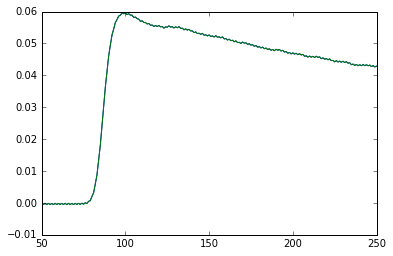

In [7]:
dataset = Waveform(path="RefPulse009.root")

BATCH_SIZE = 5000

data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=3) 

In [36]:
n_batches = int(len(dataset)/BATCH_SIZE)
print(len(dataset))
print(n_batches)
del dataset

4028
0


In [22]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32,

In [23]:
GEN.load_state_dict(torch.load("GEN_WEIGHT_half.pkl"))

In [24]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

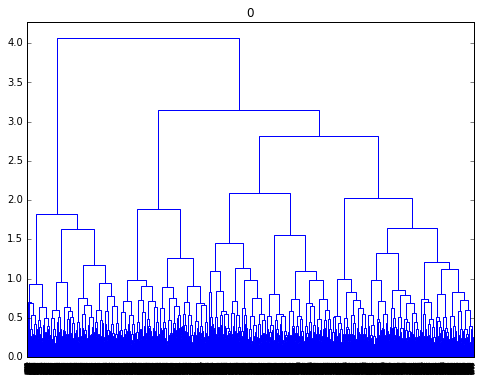

[1 2]
overall =  50.0
label 1 =  20.80436941410129
label 2 =  79.19563058589871


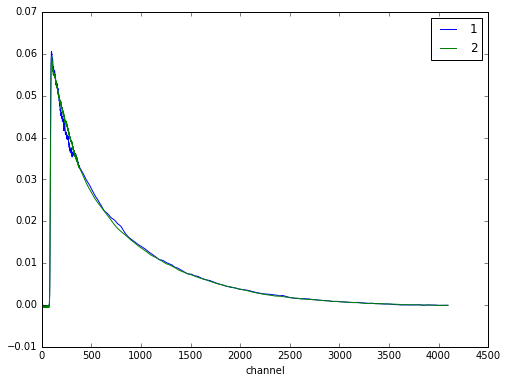

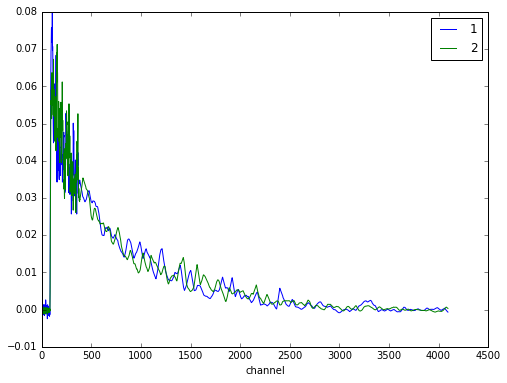

CPU times: user 31.6 s, sys: 3.32 s, total: 35 s
Wall time: 33.2 s


In [49]:
%%time
from scipy.cluster import hierarchy

try:
    for batch_number, (waveform, label) in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []
#         print(batch_number,label.size())
#         print(waveform.size())
#         if batch_number == 1:
#             break
        batch_size = waveform.size()[0]
#         print(batch_size)
#         waveform_in = to_var(waveform.view(batch_size,4096))
#         print(waveform_in)
        
#         plt.figure()
#         plt.plot(waveform[0])
#         plt.show()
        
        feat = GEN(waveform.view(batch_size,1,4096).float())
#         features = GEN.encoder(waveform_in)
        
#         print(batch_number)
#         print(feat[0].size())
        
        green = np.reshape(feat[1].detach().numpy(),(batch_size,-1))
#         print(green.shape)
        test_x = fc.linkage(green, method="ward")


#         Z = linkage(green, method="ward")
#         print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(8, 6))
        dn = dendrogram(test_x, count_sort=True, color_threshold=0)
        plt.title(batch_number)
#         plt.savefig("ls.png")
        plt.show()
    
#         dn = dendrogram(Z, color_threshold=0)
#         plt.title(batch_number)
# #         plt.savefig("ls.png")
#         plt.show()
        
#         clusters = fcluster(test_x, 8, depth=10)
# #         print(clusters.shape)
#         print(clusters[:20])
#         print(np.unique(clusters))
              
        iclusters = fcluster(test_x, 2, criterion='maxclust')
#         print(clusters.shape)
#         print(label[:20])
#         print(iclusters[:20])
        print(np.unique(iclusters))
        
#         print(iclusters.shape, label.shape)
        
        label = label.detach().numpy()
        
        correct = np.mean(label == iclusters)
                
        tot = len(label)
        c1 = np.count_nonzero(label==1)
        c2 = np.count_nonzero(label==2)
        
        correct1 = np.zeros(tot)
        correct2 = np.zeros(tot)
        
        for i in range(tot):
            if iclusters[i]==1 and label[i]==1:
                correct1[i] = 1
            if iclusters[i]==2 and label[i]==2:
                correct2[i] = 1
        
        print("overall = ", correct*100)
        print("label 1 = ", np.count_nonzero(correct1==1)/c1*100)
        print("label 2 = ", np.count_nonzero(correct2==1)/c2*100)
#         average = np.append(average,Z)
        
        for i, waveform_out in enumerate(feat[0]):
            
#             red = waveform_out.detach().numpy()
#             red = np.reshape(waveform_out.detach().numpy(), (1,-1))
            blue = waveform[i].detach().numpy()
#             blue = normalize(waveform_in[i].detach().numpy(),axis=1)

#             print(i, red.shape,blue.shape)
#             print(red[0])
#             print(blue[0])len

#             plt.figure()
#             plt.title("{}".format(clusters[i]))
# #             plt.plot(red[0],label="encoder output",alpha=0.7)
#             plt.plot(blue[0],label="encoder input",alpha=0.7)
#             plt.legend()
# #             plt.savefig("fig/autoencoder{}.png".format(i))
#             plt.show()
    
#             for k in range(len(np.unique(clusters))):
#                 if k==clusters[i]:
#                     plt.figure()
#                     plt.title("{}".format(k))
#                     plt.plot(red[0],label="encoder output",alpha=0.7)
#                     plt.plot(blue[0],label="encoder input",alpha=0.7)
#                     plt.legend()
# #                     plt.savefig("fig/{}_{}.png".format(k,i))
#                     plt.show()

            if iclusters[i]==1:
                average.append(blue)
                
            if iclusters[i]==2:
                average2.append(blue)
            
#             if clusters[i]==3:
#                 average3.append(blue[0])
                
#             if clusters[i]==4:
#                 average4.append(blue[0])
                
#             if clusters[i]==5:
#                 average5.append(blue[0])
                
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
#         dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
#         dang5 = np.mean(average5, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
#         plt.plot(dang3,label="3")
#         plt.plot(dang4,label="4")
#         plt.plot(dang5,label="5")
#         plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
#         plt.title(batch_number)
#         plt.savefig("ls3.png")
        plt.show()
        
        plt.figure(figsize=(8,6))
        plt.plot(average[0], label="1")
        plt.plot(average2[0], label="2")
#         plt.plot(average3[0])
#         plt.plot(average4[0])
#         plt.xlim(50,400)
        plt.xlabel("channel")
        plt.legend()
# #         plt.title(batch_number)
# #         plt.savefig("lsr.png")
        plt.show()
        
        
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')